# This Notebook creates some plots and analyses my_databse

**Channel 1-4**: "old cable", broke in middle

**Channel 5-8**: EGRT cable, installed for an EGRT. Could not installed until bottom of shaft. Some cable lays at surface.

Length description are individual for every Channel. When avearaging two channels which measure the same fibre you should flip one channel. So every fibreporsition is avearaged with the same fibre positions measured from the other channel. These positions have a different length index for both channels.

After processing the indexex dont start from zero and some gaps in between, maybe I should reindex them after processing. But that could cause confusion in the long run. For example when trying out a different processing or work with the unprocessed data.

### Nach jedem neuen QuickStart (neue Konfiguration) sind Datensprünge zu sehen?
Bei neuen Anschluss des EGRT kabels deulich zu sehen. Falls das so ist , evtl upport fragen warum? und gucken ob ich in den Daten irgendwo noch Sprünge finde, sodass ich die älteren Daten kalibrieren kann.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from ipywidgets import interact
import ipywidgets as widgets
from copy import deepcopy#, copy
import statistics
from random import randrange
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from shutil import copy2 as copy_file
import math

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year
from my_func_mvw.functions import find_nearest_date, calc_diff_between_channels, watertank_shift, read_pickle, write_pickle, temp_watertank_func, random_date, check_first_last_date, cut_dataframe_to_range_tlogger, check_processed_data

plot_save=False #True False


# linearen Trend der Tempertur über Kabellänge berücksichtigen?
# verringert evntl differenz zu solexperts Daten --> würde unterschied noch größer machen

#plot erstellen, der Temp änderrungen über die Zeit zeigt. Anhand von Standartabweichung oder so. Damit lässt sich dann denke ich sehr gut der Schachtbeginn begründen, da Übergang von Surface zu geschlossenen? Raum.

# avearage first könnte ich auch noch anders bestimmen, siehe Abschnit für genauere erklärung der Idee

# !!!!!!!!Ich muss einen Test machen indem ich die Temp vom Kabel ändere!!!!!!!!!!!!!!!!!!!!!!!!!!
    # für abkühlung des wassertanks eiswürfel kaufen 10 kg oder so und in tank rein. Am besten irgendwie an Boden in Box fixieren, damit es irgendwie gleichmäßig abkühlt und nicht eiswürfel direkt am kabel liegen

# watertank positionen 56 und 78 trennen, spleißen kann unterschiedlich viel Kabel verbrauchen?
    # dann müsste ich alle seperat betrachten, wegen den pigtails
    # brauche ich denke ich nicht machen

############To DO#######################
# Wenn ich die Wassertankposition 100 % final bestimmt habe, auch gucken, dass die Differenzen zwischen den CHanneln 5-6, keine starken peaks haben.
# Starke peaks deuten denke ich darauf hin, dass nicht genau die gleichen Positionen geavearaged werden.
# Vorallem am Übergang zum Wasser oder in Schacht rein zu sehen. Evntl auch versuchen um weniger als einen Meter zu verschieben. 
#
# Wasserstant über die Zeit anhand von Temperatursprung beobachten, hat Daniel das schon gemacht
#   plot erstellen, mit x-AchseZeit y-Achse Wasserstand

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")

Some Version information of the imported packages
pandas version: 1.2.3
pickle version: 4.0


In [3]:
#1min 56s

# # Load csv data
path_to_my_database = r"..\Alsdorf\Daten\my_database"
# data_2019 = import_my_database_csv(2019, path_to_my_database + r"\csv")
# data_2020 = import_my_database_csv(2020, path_to_my_database + r"\csv")
# data_2021 = import_my_database_csv(2021, path_to_my_database + r"\csv")

#7.64 s

# Load pickle Data
path_to_my_database_pickle = path_to_my_database + r"\pickle"
data_2021=import_my_database_pickle(2021, path_to_my_database_pickle)
data_2020=import_my_database_pickle(2020, path_to_my_database_pickle)
data_2019=import_my_database_pickle(2019, path_to_my_database_pickle)

data_all = read_pickle(path_to_my_database + "\..\my_database_additional_local\data_all")
# delete other cable channels
for old_chan in ["1","2","3","4"]:
    del data_all[old_chan]

read_pickle(path_to_my_database + "\..\my_database_additional_local\data_all")

# load some processed data
chan_mean_avearagefirst = read_pickle(path_to_my_database + "\..\my_database_additional_local\chan_mean_avearagefirst")
watertank_diff_log_data_all = read_pickle(path_to_my_database + "\..\my_database_additional_local\watertank_diff_log_data_all")
data_all_processed_shifted = read_pickle(path_to_my_database + "\..\my_database_additional_local\data_all_processed_shifted")
watertank_diff_log_avearagefirst = read_pickle(path_to_my_database + "\..\my_database_additional_local\watertank_diff_log_avearagefirst")
chan_mean_shiftfirst = read_pickle(path_to_my_database + "\..\my_database_additional_local\chan_mean_shiftfirst")
data_all_processed = read_pickle(path_to_my_database + "\..\my_database_additional_local\data_all_processed")
Schacht_7and8_0_down = read_pickle(r"..\Alsdorf\Daten\my_database\shaft_final_temperature\egrt_cable\pickle"+"\\Schacht_7and8_down")
Schacht_7and8_0_up = read_pickle(r"..\Alsdorf\Daten\my_database\shaft_final_temperature\egrt_cable\pickle"+"\\Schacht_7and8_up")

chan5and6_mean = chan_mean_shiftfirst["5and6"]
chan7and8_mean = chan_mean_shiftfirst["7and8"]

In [4]:
# import tlogger
# read csv
# Tlogger_PT1000 = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000.csv", index_col=[0])
# Tlogger_PT100  = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated.csv",index_col=[0])
# Tlogger_PT100.index.names=["Date"]; Tlogger_PT1000.index.names=["Date"]
# Tlogger_PT100.index = pd.to_datetime(Tlogger_PT100.index); Tlogger_PT1000.index = pd.to_datetime(Tlogger_PT1000.index)

#read_pickle
df_Tlogger_PT1000 = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000")
df_Tlogger_PT100  = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated")

watertank_T_range_min = df_Tlogger_PT100.index.min()
watertank_T_range_max = df_Tlogger_PT100.index.max()

watertank_len=[25,1689,1723,3389] # position DTS cable, where it is in watertank; vorher [19,1690,1723,3389]

df_Tlogger_PT100

,Channel1-Watertank_PT100,Channel2-Air,Channel1-PT100_rolling_mean
2021-06-07 12:12:40,23.4,25.8,23.5
2021-06-07 12:13:40,23.5,25.4,23.5
2021-06-07 12:14:40,23.4,25.2,23.5
2021-06-07 12:15:40,23.5,24.9,23.5
2021-06-07 12:16:40,23.5,24.8,23.5
...,...,...,...
2021-08-09 10:28:14,20.6,NaN,20.6
2021-08-09 10:31:14,20.6,NaN,20.6
2021-08-09 10:34:14,20.6,NaN,20.6
2021-08-09 10:37:13,20.6,NaN,20.6


In [5]:
df_Tlogger_PT1000

,Channel1_PT1000,Channel2_PT1000,Channel1-PT1000_rolling_mean
2021-08-04 11:18:42,20.5,20.5,20.4
2021-08-04 11:21:42,20.4,20.5,20.4
2021-08-04 11:24:42,20.4,20.4,20.4
2021-08-04 11:27:42,20.4,20.4,20.4
2021-08-04 11:30:42,20.4,20.5,20.4
...,...,...,...
2021-08-09 10:28:14,20.6,20.5,20.6
2021-08-09 10:31:14,20.6,20.5,20.6
2021-08-09 10:34:14,20.6,20.5,20.6
2021-08-09 10:37:13,20.6,20.5,20.6


In [6]:
# plt.figure(figsize=(16,5))
# val=16000
# y=df_Tlogger["Channel1-rolling_mean"].values[val:]
# x_dates=df_Tlogger["Channel1-rolling_mean"].index[val:]
# plt.scatter(x_dates,y,label="Watertank-Temp rolling_mean",color="red",zorder=10)

In [7]:
# shorten T-logger so gaps are not in dataframe, I need to adapt my functions to the data gaps
# df_Tlogger = df_Tlogger.iloc[:15500]
# df_Tlogger

# Wireline T-Logger

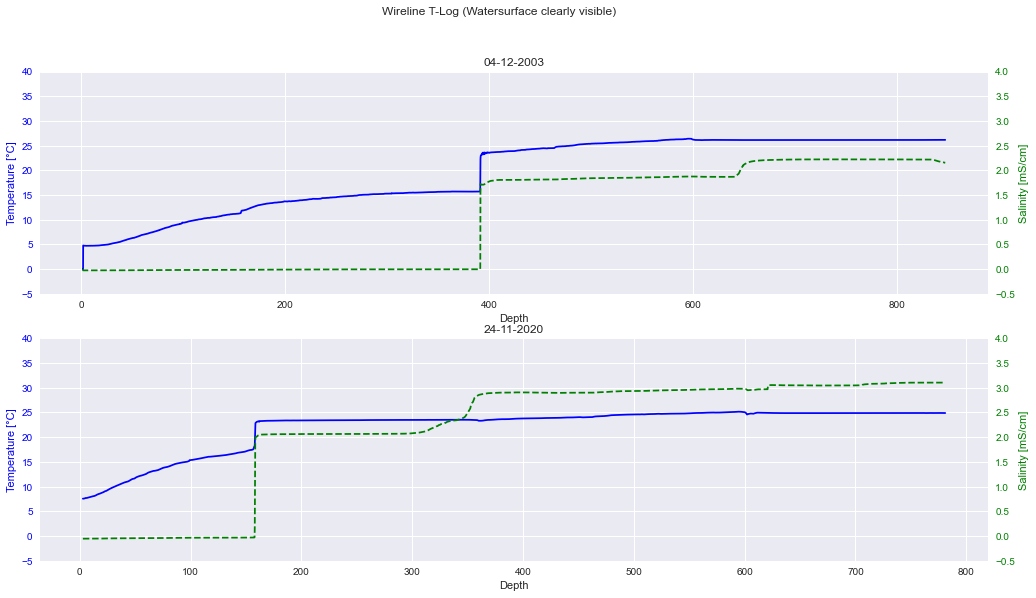

In [8]:
# Load Data
path_to_wireline = path_to_my_database + "\PTS_Logs"

filename2003=r"\PTS_2003.csv"
wireline_measurements2003 = pd.read_csv(path_to_wireline + filename2003,skiprows=[0,2,3],index_col=0,na_values=-999.0)
wireline_measurements2003.columns = ["BHT","CBLE_ACC","CURRENT","DIFF-TENSION0","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME","VOLTAGE"] #rename columns, because the original names contain empty spaces
wireline_measurements2003 = wireline_measurements2003.dropna()

filename2020=r"\PTS_20201124.csv"
wireline_measurements2020 = pd.read_csv(path_to_wireline + filename2020,index_col=0,skiprows=[0,2,3],na_values=-999.0)
wireline_measurements2020.columns = ["BHT","DEPTH.1","dPress","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME"]
wireline_measurements2020 = wireline_measurements2020.drop(columns=["DEPTH.1"]) # the same as DEPTH column
wireline_measurements2020 = wireline_measurements2020.dropna() # drop some nan rows
wireline_measurements2020

# Plot the data
##########Inputs##########
ymin=-5;ymax=40
cBHT="blue";cSAL="green"
lstyle_BHT="-";lstyle_SAL="--"
######################
fig,axs=plt.subplots(2,1,figsize=[17,9])#,constrained_layout=True)
fig.suptitle("Wireline T-Log (Watersurface clearly visible)")
#fig.tight_layout()

axs[0].set_title("04-12-2003") # First axes

axs[0].plot(wireline_measurements2003["BHT"].index,wireline_measurements2003["BHT"].values,color=cBHT,linestyle=lstyle_BHT)#label="Bottom Hole Temperature"
axs[0].set_xlabel("Depth")
axs[0].set_ylabel("Temperature [°C]",color=cBHT)
axs[0].set_ylim(ymin,ymax) # both y-axis have similar scale --> helper lines are alligned
axs[0].tick_params(axis='y', labelcolor=cBHT)

axs0_2 = axs[0].twinx()
axs0_2.plot(wireline_measurements2003["SAL"].index,wireline_measurements2003["SAL"].values,color=cSAL,linestyle=lstyle_SAL)#,label="Salinity")
axs0_2.set_ylabel('Salinity [mS/cm]', color=cSAL)
axs0_2.set_ylim(ymin/10,ymax/10) # both y-axis have similar scale --> helper lines are alligned
axs0_2.tick_params(axis='y', labelcolor=cSAL)
# The grids are not alligned, if not using .set_ylim()
axs0_2.grid(None) #axs is behind the helper lines

axs[1].set_title("24-11-2020") # Second axes

axs[1].plot(wireline_measurements2020["BHT"].index,wireline_measurements2020["BHT"].values,color=cBHT,linestyle=lstyle_BHT)#label="Bottom Hole Temperature"
axs[1].set_xlabel("Depth")
axs[1].set_ylabel("Temperature [°C]",color=cBHT)
axs[1].set_ylim(ymin,ymax) # both y-axis have similar scale --> helper lines are alligned
axs[1].tick_params(axis='y', labelcolor=cBHT)

axs1_2 = axs[1].twinx()
axs1_2.plot(wireline_measurements2020["SAL"].index,wireline_measurements2020["SAL"].values,color=cSAL,linestyle=lstyle_SAL)#,label="Salinity")
axs1_2.set_ylabel('Salinity [mS/cm]', color=cSAL)
axs1_2.set_ylim(ymin/10,ymax/10) # both y-axis have similar scale --> helper lines are alligned
axs1_2.tick_params(axis='y', labelcolor=cSAL)
# The grids are not alligned, if not using .set_ylim()
axs1_2.grid(None) #axs is behind the helper lines

#plt.legend()
plt.show()

# Wie genau funktioniert das gerät, es zeichnet nur den höchsten Wert auf oder?


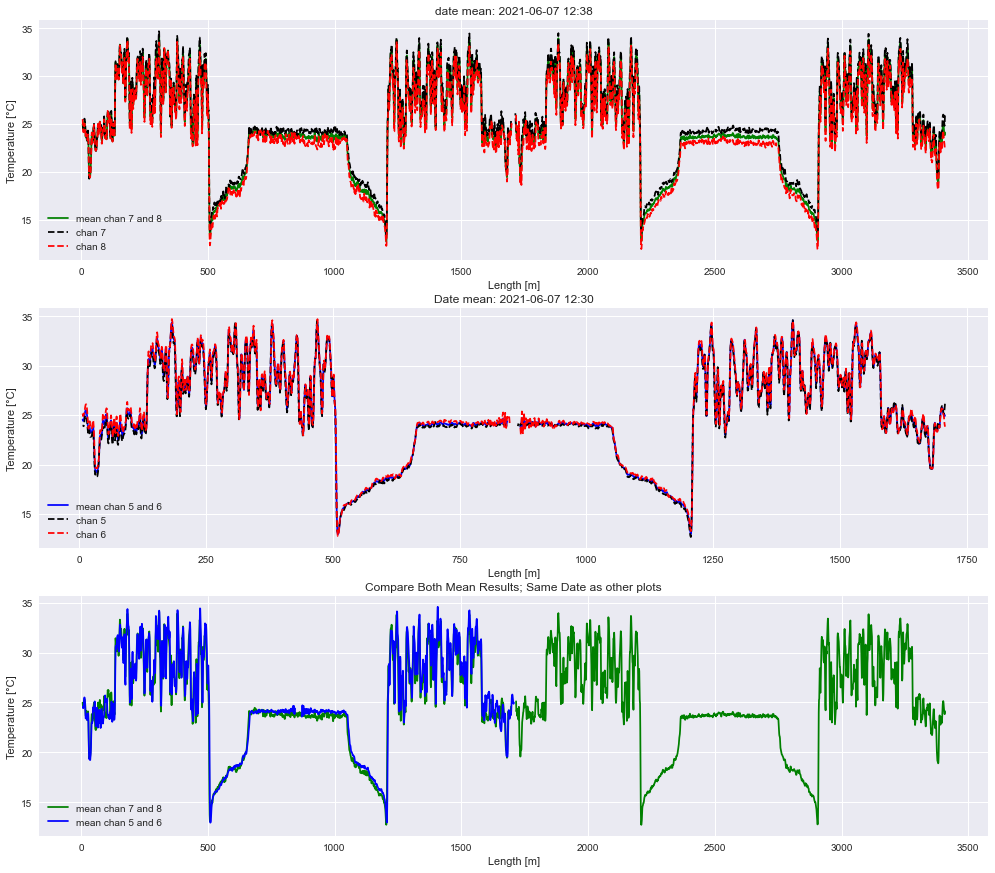

be aware, that for calculating the mean one courve has to be shifted for a few (4) minutes


In [9]:
# SOllte ich denke ich auf const shift ändern !!!!!!!!!!!

# Plot mean values compared to channel values
# the songle channels are plooted, like they are used in the mean calculation. Every point which is avearaged with an other ist plotted at the same position, therfore one channel has been flipped.
date_iloc=0 #change me
fig,axs=plt.subplots(3,1,figsize=[17,15])#,constrained_layout=True)

axs[0].plot(chan7and8_mean.iloc[date_iloc].index,chan7and8_mean.iloc[date_iloc].values, label="mean chan 7 and 8", color="green")
# get correspnding dates of chan 7 and 8
date_name_ch7, date_iloc_ch7 = find_nearest_date(chan7and8_mean.iloc[date_iloc].name,data_all_processed_shifted["7"].index)
date_name_ch8, date_iloc_ch8 = find_nearest_date(chan7and8_mean.iloc[date_iloc].name,data_all_processed_shifted["8"].index)
# flip channel 7, also done for mean calculation
axs[0].plot(data_all_processed_shifted["7"].loc[date_name_ch7].index[::-1], data_all_processed_shifted["7"].loc[date_name_ch7].values, label="chan 7",linestyle="--", color="black")
axs[0].plot(data_all_processed_shifted["8"].loc[date_name_ch8].index, data_all_processed_shifted["8"].loc[date_name_ch8].values, label="chan 8",linestyle="--", color="red")
axs[0].set_title(f"date mean: {chan7and8_mean.iloc[date_iloc].name.strftime('%Y-%m-%d %H:%M') }") # drop seconds

axs[1].plot(chan5and6_mean.iloc[date_iloc].index,chan5and6_mean.iloc[date_iloc].values, label="mean chan 5 and 6", color="blue")
# get correspnding dates of chan 5 and 6
date_name_ch5, date_iloc_ch5 = find_nearest_date(chan5and6_mean.iloc[date_iloc].name,data_all_processed_shifted["5"].index)
date_name_ch6, date_iloc_ch6 = find_nearest_date(chan5and6_mean.iloc[date_iloc].name,data_all_processed_shifted["6"].index)
# flip channel 5, also done for mean calculation
axs[1].plot(data_all_processed_shifted["5"].loc[date_name_ch5].index[::-1], data_all_processed_shifted["5"].loc[date_name_ch5].values, label="chan 5",linestyle="--", color="black")
axs[1].plot(data_all_processed_shifted["6"].loc[date_name_ch6].index, data_all_processed_shifted["6"].loc[date_name_ch6].values, label="chan 6",linestyle="--", color="red")
axs[1].set_title(f"Date mean: {chan5and6_mean.iloc[date_iloc].name.strftime('%Y-%m-%d %H:%M')}") # drop seconds

axs[2].plot(chan7and8_mean.iloc[0].index,chan7and8_mean.iloc[date_iloc].values, label="mean chan 7 and 8", color="green")
axs[2].plot(chan5and6_mean.iloc[0].index,chan5and6_mean.iloc[date_iloc].values, label="mean chan 5 and 6", color="blue")
axs[2].set_title(f"Compare Both Mean Results; Same Date as other plots")

for ax in axs:
    ax.set_xlabel("Length [m]")
    ax.set_ylabel("Temperature [°C]")
    ax.legend()

plt.show()
print("be aware, that for calculating the mean one courve has to be shifted for a few (4) minutes")

# Plot Data

In [11]:
def interactive_plot_function(data_type,channel,date,display_from,display_to,ymin,ymax,show_mean_chan5and6,show_mean_chan7and8,color_plot,plot_wireline,offset_wireline,offset_old_cable):

    if data_type == "data_all_unprocessed":
        data = data_all
    elif data_type == "data_all_processed_shifted":
        data = data_all_processed_shifted
    
    # I need to define this function in here, so it can be used in interactive.
    def color_cable_pos(start_len, end_len, col, ymax, ymin, label_name, label=True):
        """ creates patches which color the plot"""
        width = end_len - start_len
        Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax+ymin,color=col,alpha=0.2)
        axs.add_patch(Rectangle)
        if label and display_from < start_len+width/2 and display_to > start_len+width/2:
            #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
            bbox_props=dict(boxstyle="round",fc=col, ec="0.5", alpha=0.0)
            axs.text(start_len+width/2,ymax-(ymax-ymin)*0.1,label_name,ha="center",va="center",size=15,bbox=bbox_props)
    
    val={}
    fig,axs=plt.subplots(1,1,figsize=[18,5],constrained_layout=True)
    # Plot Data
    for chan in channel:
        length=data[chan].iloc[date].index[display_from:display_to]
        x=np.array(length).astype(int)
        val[chan]=np.array(data[chan].iloc[date].values)[display_from:display_to]
        date_name=data[chan].iloc[date].name
        y=val[chan]
        if chan in ["1","2","3","4"]:# both cables have a different legnth to the shaft
            if display_from <= offset_old_cable:
                length=data[chan].iloc[date].index[0:display_to-offset_old_cable]
                val[chan]=np.array(data[chan].iloc[date].values)[0:display_to-offset_old_cable]
            else:
                length=data[chan].iloc[date].index[display_from-offset_old_cable:display_to-offset_old_cable]
                val[chan]=np.array(data[chan].iloc[date].values)[display_from-offset_old_cable:display_to-offset_old_cable]
            x=np.array(length).astype(int)
            x=x+offset_old_cable
            y=val[chan]
        axs.plot(x,y,label=f"channel {chan}")

    if data_type == "data_all_unprocessed":
        axs.set_title(f"uncorrected data from {data[chan].iloc[date].name}")
    if data_type == "data_all_processed_shifted":
        axs.set_title(f"corrected processed data from {data[chan].iloc[date].name}")
    if data_type == "nothing: select channel []":
        axs.set_title(f"plotted nothing")

    axs.set_ylim(ymin,ymax)
    axs.set_xlim(display_from,display_to)
    axs.set_xlabel("Length [m]")
    axs.set_ylabel("Temperature [°C]")

    if plot_wireline:
        #offset_wireline: offset, so that curve fits to EGRT cable
        length = wireline_measurements2003["BHT"].index + offset_wireline
        Temp   = wireline_measurements2003["BHT"].values
        axs.plot(length, Temp, label="Wireline T-Log\n04.12.2003")
        length = wireline_measurements2020["BHT"].index + offset_wireline
        Temp   = wireline_measurements2020["BHT"].values
        axs.plot(length, Temp, label="Wireline T-Log\n24.11.2020")

    # Avearage first
    # if show_mean_chan5and6:
    #     length_mean56=chan_mean_avearagefirst["5and6"].iloc[date].index[display_from:display_to]
    #     x=np.array(length_mean56).astype(int)
    #     y=chan_mean_avearagefirst["5and6"].iloc[date].values[display_from:display_to] #- diff_in_watertank[chan]
    #     date_name_chan56=chan_mean_avearagefirst["5and6"].iloc[date].name
    #     axs.plot(x, y,label=f"channel mean 5 and 6\nDate: {date_name_chan56}")

    # if show_mean_chan7and8:
    #     length_mean78=chan_mean_avearagefirst["7and8"].iloc[date].index[display_from:display_to]
    #     x=np.array(length_mean78).astype(int)
    #     y=chan_mean_avearagefirst["7and8"].iloc[date].values[display_from:display_to] #- diff_in_watertank[chan]
    #     date_name_chan78=chan_mean_avearagefirst["7and8"].iloc[date].name
    #     axs.plot(x, y,label=f"channel mean 7 and 8\nDate: {date_name_chan78}")
    
    # Shiftfirst
    if show_mean_chan5and6:
        length_mean56=chan_mean_shiftfirst["5and6"].iloc[date].index[display_from:display_to]
        x=np.array(length_mean56).astype(int)
        y=chan_mean_shiftfirst["5and6"].iloc[date].values[display_from:display_to] #- diff_in_watertank[chan]
        date_name_chan56=chan_mean_shiftfirst["5and6"].iloc[date].name
        axs.plot(x, y,label=f"channel mean 5 and 6\nDate: {date_name_chan56}")

    if show_mean_chan7and8:
        length_mean78=chan_mean_shiftfirst["7and8"].iloc[date].index[display_from:display_to]
        x=np.array(length_mean78).astype(int)
        y=chan_mean_shiftfirst["7and8"].iloc[date].values[display_from:display_to] #- diff_in_watertank[chan]
        date_name_chan78=chan_mean_shiftfirst["7and8"].iloc[date].name
        axs.plot(x, y,label=f"channel mean 7 and 8\nDate: {date_name_chan78}")
        
    #splice_pos=1707 # splice position of long cable, not exactly at middle due to pig tail
    #plt.vlines(splice_pos,5,40, color="black",label="splice position?")
    #plt.vlines([splice_pos+10,splice_pos-10,splice_pos+17,splice_pos-17],5,40,label="watertank position?")
    #plt.vlines([splice_pos+14,splice_pos-14],ymin=5,ymax=40,label="watertank position?",linestyles="dashed")
    #plt.vlines([1580,1595],ymin=5,ymax=40,label="watertank position?",linestyles="dashed")

    # # Positions Cable buried - txt field
    # size=11; y=25; ha="center"; va="center"
    # bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    # x=36
    # if display_from < x and display_to > x:
    #     y=data_all[chan].iloc[date][x] - 8
    #     plt.text(x, y,"Cable buried", ha=ha, va=va, size=size, bbox=bbox_props)
    # x=130
    # if display_from < x and display_to > x:
    #     y=data_all[chan].iloc[date][x] - 8
    #     plt.text(x, y,"Cable buried", ha=ha, va=va, size=size, bbox=bbox_props)
    #axs[n].vlines(start_time_alsd, ymin=0, ymax=330, label="Approx. start of Alsdorf Data", colors="black",linestyles="-")

    if color_plot == True:
        # Beginn water?
        axs.vlines(668,ymin,ymax, color="blue", label="begin water")
        axs.vlines(1050,ymin,ymax, color="blue")
        color_cable_pos(668,1050,"blue",ymax,ymin,label_name="Water")
        axs.vlines(859,ymin,ymax, color="blue", linestyle="--", label="bend point") # Bend point?
        if "7" in channel or "8" in channel:
            axs.vlines(2368,ymin,ymax, color="blue")
            axs.vlines(2750,ymin,ymax, color="blue")
            color_cable_pos(2368,2750,"blue",ymax,ymin, label_name="Water")
            axs.vlines(2559,ymin,ymax, color="blue", linestyle="--") # Bend point?
        # this means the cable goes 355 m deep in the shaft: bend point - Surface: 859 - 504; 2559 - 2203
        # the water table is 668 - 504 = 164 m depth: water table - surface 
        # other numbers 2368 - 2203 = 165 m depth
        # Passt zur Ausbauskizze von 2019, da waren es 169 m
        
        # Cable Buried; two positions are buried: 1, 2
        color_cable_pos(31,41,"brown",ymax,ymin,label_name="Buried",label=False) #1
        color_cable_pos(121,134,"brown",ymax,ymin,label_name="Buried",label=False)#2
        color_cable_pos(1580,1593,"brown",ymax,ymin,label_name="Buried",label=False)#2
        color_cable_pos(1674,1684,"brown",ymax,ymin,label_name="Buried",label=False)#1
        if "7" in channel or "8" in channel:
            color_cable_pos(1732,1742,"brown",ymax,ymin,label_name="Buried",label=False)#1
            color_cable_pos(1820,1833,"brown",ymax,ymin,label_name="Buried",label=False)#1
            color_cable_pos(3280,3293,"brown",ymax,ymin,label_name="Buried",label=False)#2
            color_cable_pos(3374,3384,"brown",ymax,ymin,label_name="Buried",label=False)#1

        #Position cable Fence
        color_cable_pos(1593,1674,"green",ymax,ymin,label_name="Fence")
        color_cable_pos(41,121,"green",ymax,ymin,label_name="Fence")
        if "7" in channel or "8" in channel:
            color_cable_pos(1742,1820,"green",ymax,ymin,label_name="Fence")
            color_cable_pos(3293,3374,"green",ymax,ymin,label_name="Fence")

        #Position cable at surface 
        color_cable_pos(134,508,"yellow",ymax,ymin,label_name="Surface")
        color_cable_pos(1210,1580,"yellow",ymax,ymin,label_name="Surface")
        if "7" in channel or "8" in channel:
            color_cable_pos(1833,2203,"yellow",ymax,ymin,label_name="Surface")
            color_cable_pos(2910,3280,"yellow",ymax,ymin,label_name="Surface")

        #Position cable Watertank -------------unsure-----------should change Temp of watertank to be sure
        color_cable_pos(18,20,"blue",ymax,ymin,label_name="Watertank",label=False)
        axs.vlines(18,ymin,ymax, color="black", label="Watertank")
        axs.vlines(20,ymin,ymax, color="black")
        #data["5"].columns[-20] # --> 1689; -20 because last value corresponds to 0
        color_cable_pos(1689,1691,"blue",ymax,ymin,label_name="Watertank",label=False)
        axs.vlines(1689,ymin,ymax, color="black")
        axs.vlines(1691,ymin,ymax, color="black")
        if "7" in channel or "8" in channel:
            color_cable_pos(1722,1724,"blue",ymax,ymin,label_name="Watertank",label=False)
            axs.vlines(1722,ymin,ymax, color="black")
            axs.vlines(1724,ymin,ymax, color="black")
            color_cable_pos(3388,3390,"blue",ymax,ymin,label_name="Watertank",label=False)
            axs.vlines(3388,ymin,ymax, color="black")
            axs.vlines(3390,ymin,ymax, color="black")

    axs.legend()
    #save_path = "pictures/overview.png"
    #save_path_dpi720 = "pictures/dpi720/overview_dpi720.png"
    #plt.savefig(save_path)
    #plt.savefig(save_path_dpi720, dpi=720)
    plt.show()

In [12]:
# Color Plot for EGRT cable - Interactive
# maybe this libary is better:
# I think this includes some hovering information 
#https://plotly.com/python/creating-and-updating-figures/ # mpsste da mal ein basic tutoial zu machen
#implementing hovering in matplotlib is rather difficult
#https://stackoverflow.com/questions/7908636/is-it-possible-to-make-labels-appear-when-hovering-mouse-over-a-point-in-matplot
#I use this libary:
#https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#interactive

interact(interactive_plot_function,
data_type=["data_all_processed_shifted","data_all_unprocessed","nothing: select channel []"],
channel=[["5","6"],["7","8"],["5","6","7","8"],"1","2","3","4","5","6","7","8",["1","2","3","4"],["1","2","3","4","5","6","7","8"],[]],
date=widgets.IntSlider(min=0, max=310, step=1, value=10), # not optimal
display_from=widgets.IntSlider(min=0, max=3350, step=10, value=0), 
display_to=widgets.IntSlider(min=10, max=3700, step=10, value=1950),
ymin=widgets.IntSlider(min=0, max=100, step=5, value=5),
ymax=widgets.IntSlider(min=5, max=100, step=5, value=50),
color_plot=True,
plot_wireline=False,
show_mean_chan5and6=False,
show_mean_chan7and8=False,
offset_wireline=widgets.IntSlider(min=0, max=3000, step=2, value=508), #value is same as end cable surface color
offset_old_cable=widgets.IntSlider(min=0, max=3000, step=2, value=306))
print("means are avearagefirst means (of one date, not all dates)")
#from last measurements; compare -20 and -265 for determine of colors; range 0 bis 310

# Ideen:
# this means the cable goes 355 m deep in the shaft: bend point - Surface: 859 - 504
# other numbers: 2559 - 2203 = 356 m
# the water table is 668 - 504 = 164 m depth: water table - surface 
# other numbers 2368 - 2203 = 165 m depth
# Passt zur Ausbauskizze von 2019, da waren es 169 m
# Ist seit der Wireline Messung das Wasser über 200 m angestiegen? Bedeutet Sprung in Wireline-log nicht beginn Wasser?

# Pegelmessung aus IP noch einfügen

############Werte noch mit Notizen von Kabellänge überprüfen!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# In sich sind die Werte nicht ganz stimmig! (ein paar Meter Abweichung)
#   --> coloring positionen noch leicht anpassen, sodass alle Flächen gleich groß sind

# Vergleiche Plots:
# S. 25 Green Abschlussbericht
# Anl_04_433_15_004.pdf
# Wireline Plot

# Differenz von Chan 1-4 zu Chan 5-8 in Schacht Luft liegt an position? Wo gehen die beiden Kabel genau lang?
# egrt Kabel geht durch seperaten Röhre

interactive(children=(Dropdown(description='data_type', options=('data_all_processed_shifted', 'data_all_unpro…

means are avearagefirst means (of one date, not all dates)


# Compare Differences of Corrected Data

In [13]:
def diff_to_watertank(data_calc, find_nearest_date = find_nearest_date, watertank_len = watertank_len, watertank_T_range_min = watertank_T_range_min, watertank_T_range_max = watertank_T_range_max):
    """Calculate differences of corrected values to watertank
    alle variables I need and defined before are as default inputs

    pos: Temp von DTS höher als in Wassertank
    neg: Temp von DTS niedriger als in Wassertank
    """
    
    diff_watertank_aftercorr_alldates={}
    for chan in data_calc.keys():
        # df for watertank diffs of corrected values
        diff_watertank_aftercorr = pd.DataFrame(index=watertank_len)
            
        # # find the date range of this channel, which also is covered by the T-Logger
        # # Im prinzip unnötig, da corrected value eh komplett gecoverde sind von T-logger
        # date_name_min, date_iloc_min = find_nearest_date(watertank_T_range_min,data_calc[chan].index)
        # date_name_max, date_iloc_max = find_nearest_date(watertank_T_range_max,data_calc[chan].index)
        # all_dates_in_range_channel   = data_calc[chan].index[date_iloc_min:date_iloc_max]

        for date_name in data_calc[chan].index:
            #date_numeric=mdates.date2num(date_name)# create numeric of date for calculations
            val_watertank=temp_watertank_func([date_name], df_Tlogger_PT100)[0]  # T of watertank, measured by PT100
            # Create dataframe to save diffs at all watertank positions after correction

            # diff at all watertankpositions after correction
            # corrected values of DTS at watertank positions
            
            if chan in ["5","6"] or chan in["5and6"]:
                # corrected values of DTS at watertank positions
                c_v_watertank0 = data_calc[chan][watertank_len[0]][date_name] # c_v: corrected value
                c_v_watertank1 = data_calc[chan][watertank_len[1]][date_name]
                diffs = [c_v_watertank0 - val_watertank, c_v_watertank1 - val_watertank, np.nan, np.nan]
                diff_watertank_aftercorr[date_name] = diffs
            elif chan in ["7","8"] or chan in ["7and8"]: 
                # these channels are longer and contain the last two watertank positions
                # corrected values of DTS at watertank positions
                c_v_watertank0 = data_calc[chan][watertank_len[0]][date_name] # c_v: corrected value
                c_v_watertank1 = data_calc[chan][watertank_len[1]][date_name]
                c_v_watertank2 = data_calc[chan][watertank_len[2]][date_name]
                c_v_watertank3 = data_calc[chan][watertank_len[3]][date_name]
                # differences
                diffs = [c_v_watertank0 - val_watertank, c_v_watertank1 - val_watertank, c_v_watertank2 - val_watertank, c_v_watertank3 - val_watertank]
                diff_watertank_aftercorr[date_name] = diffs

        # save diffs to other watertank positions of this channel in dic
        diff_watertank_aftercorr_alldates[chan] = diff_watertank_aftercorr #variable evntl. noch umbennen
    
    return diff_watertank_aftercorr_alldates


diff_watertank_afterprocess_alldates           = diff_to_watertank(data_calc = data_all_processed)
diff_watertank_aftercorr_afterprocess_alldates = diff_to_watertank(data_calc = data_all_processed_shifted)

In [15]:
# del diff_watertank_aftercorr_afterprocess_alldates["1"]
# del diff_watertank_aftercorr_afterprocess_alldates["2"]
# del diff_watertank_aftercorr_afterprocess_alldates["3"]
# del diff_watertank_aftercorr_afterprocess_alldates["4"]

In [16]:
# Calculate differences to watertank temperature at all waterank positions for all date range of T-Logger
def calc_mean_diff_watertank(data,watertank_len=watertank_len):
    """Calculate Mean values of differences at all watertank positions"""
    # Create Dataframe
    columns_mean=[]
    columns_stdev=[]
    columns = list(data.keys()) # channel numbers
    columns_stdev.append("n_data")
    for chan in columns: # change the column names
        columns_mean.append("mean: " + chan) 
        columns_stdev.append("stdev: " + chan)
    mean_diff = pd.DataFrame(index = watertank_len, columns = columns_mean)
    mean_diff.index.names    = ["Length [m]"]
    mean_diff.columns.names  = ["Channel"]
    stdev_diff = pd.DataFrame(index = watertank_len, columns = columns_stdev)
    stdev_diff.index.names   = ["Length [m]"]
    stdev_diff.columns.names = ["Channel"]

    # Calculate mean for every channel
    for chan in columns:
        if chan in ["5","6","5and6"]:
            for length in watertank_len[:2]:
                mean_diff[f"mean: {chan}"][length]  = np.nanmean(data[chan].loc[length])
                stdev_diff["n_data"][length] = len(data[chan].loc[length])
                stdev_diff[f"stdev: {chan}"][length] = np.nanstd(data[chan].loc[length])
        else: #channel 7 and 8
            for length in watertank_len:
                mean_diff[f"mean: {chan}"][length]  = np.nanmean(data[chan].loc[length])
                stdev_diff["n_data"][length] = len(data[chan].loc[length])
                stdev_diff[f"stdev: {chan}"][length] = np.nanstd(data[chan].loc[length])

    mean_stdev = pd.concat([mean_diff, stdev_diff], axis=1)
    return mean_stdev

In [17]:
print(f"curves are shifted at length {watertank_len[0]} m to watertank value")
print("at the other length they are compared to the watertank temperature")
print("these are the mean diffeneces of the absolute difference for each date")
# both means are the same, because in processing I did not change anything at the watertank position (26062021)
#mean_stdev_uncorrected = calc_mean_diff_watertank(diff_watertank_afterprocess_alldates)
mean_stdev = calc_mean_diff_watertank(diff_watertank_aftercorr_afterprocess_alldates)
print("Mean and standart deviation")
display(mean_stdev)

# Achtung mean Abweichung ist im Moment nicht von absoluten Werten berechnet!
#   evntl. noch neue Spalte in Berechnung für absolute Werte?

curves are shifted at length 25 m to watertank value
at the other length they are compared to the watertank temperature
these are the mean diffeneces of the absolute difference for each date
Mean and standart deviation


Channel,mean: 5,mean: 6,mean: 7,mean: 8,n_data,stdev: 5,stdev: 6,stdev: 7,stdev: 8
Length [m],,,,,,,,,
25,0.0,0.0,0.0,0.0,2939,0.0,0.0,0.0,0.0
1689,-0.708431,-0.129351,0.281887,0.18667,2939,0.183317,0.217466,0.303728,0.359735
1723,NaN,NaN,0.275161,1.143816,2939,NaN,NaN,0.3011,0.497081
3389,NaN,NaN,-0.502682,-1.359055,2939,NaN,NaN,0.346528,0.287772


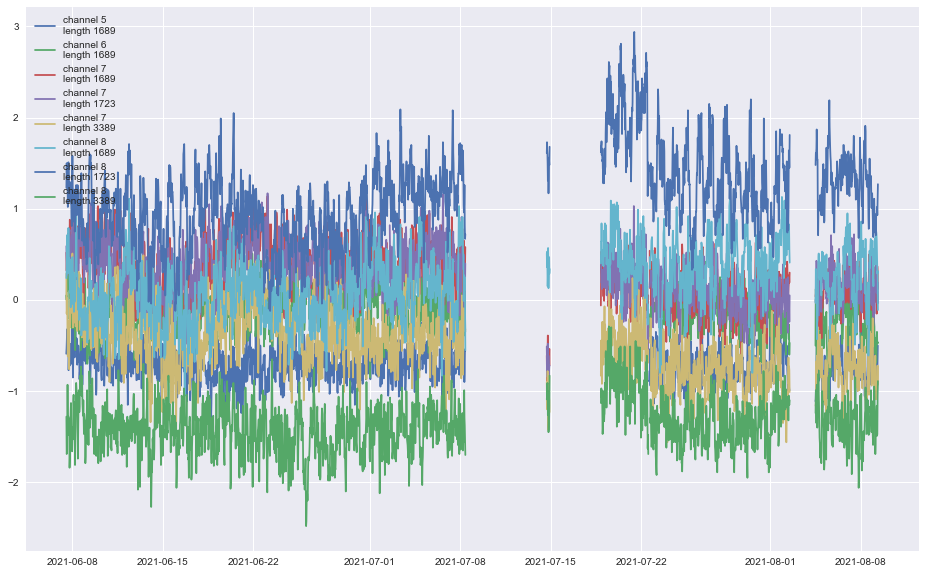

In [18]:
fig,axs=plt.subplots(1,1,figsize=[16,10])
dic_p = diff_watertank_aftercorr_afterprocess_alldates
for chan in ["5","6"]:
    ls = f"channel {chan}\nlength "
    axs.plot(dic_p[chan].loc[watertank_len[1]].index,dic_p[chan].loc[watertank_len[1]].values, label=ls+f"{watertank_len[1]}")
for chan in ["7","8"]:
    ls = f"channel {chan}\nlength "
    axs.plot(dic_p[chan].loc[watertank_len[1]].index,dic_p[chan].loc[watertank_len[1]].values, label=ls+f"{watertank_len[1]}")
    axs.plot(dic_p[chan].loc[watertank_len[2]].index,dic_p[chan].loc[watertank_len[2]].values, label=ls+f"{watertank_len[2]}")
    axs.plot(dic_p[chan].loc[watertank_len[3]].index,dic_p[chan].loc[watertank_len[3]].values, label=ls+f"{watertank_len[3]}")

axs.legend()

In [19]:
# diff watertank of the mean temperature between channels
diff_watertank_shiftfirst = diff_to_watertank(chan_mean_shiftfirst)
mean_stdev_shiftfirst = calc_mean_diff_watertank(diff_watertank_shiftfirst)
mean_stdev_shiftfirst = mean_stdev_shiftfirst.replace(pd.NA, np.nan).round(2) # replace pd.nan because round does ont work
print("mean and stdev to watertank, shift first")
display(mean_stdev_shiftfirst)

print()
diff_watertank_avearagefirst = diff_to_watertank(chan_mean_avearagefirst)
mean_stdev_avearagefirst = calc_mean_diff_watertank(diff_watertank_avearagefirst)
mean_stdev_avearagefirst = mean_stdev_avearagefirst.replace(pd.NA, np.nan).round(2)
print("mean and stdev to watertank, averaging first and after that watertank correction")
display(mean_stdev_avearagefirst)

# Comment shiftfirst: 
# I shift every channel on its own 25 m position, after that one channel is flipped.
# so the 25 m position of the flipped channel is avearaged with a position, which was not corrected
# Das verfälscht die Daten dann wieder 
#
# What happens if I shift the one channel at the opposite position?

# shift first sollte besser sein, da bei avearagefirst unterschiedliche connectorshifts bei jedem channel sind

# sepert mitteln bei channel 7 und 8?

mean and stdev to watertank, shift first


Channel,mean: 5and6,mean: 7and8,n_data,stdev: 5and6,stdev: 7and8
Length [m],,,,,
25,-0.35,-0.25,2939,0.09,0.17
1689,-0.07,0.23,2939,0.11,0.22
1723,NaN,0.71,2939,NaN,0.27
3389,NaN,-0.68,2939,NaN,0.14



mean and stdev to watertank, averaging first and after that watertank correction


Channel,mean: 5and6,mean: 7and8,n_data,stdev: 5and6,stdev: 7and8
Length [m],,,,,
25,0.00,0.00,2939,0.00,0.00
1689,0.29,0.48,2939,0.14,0.25
1723,NaN,0.96,2939,NaN,0.28
3389,NaN,-0.43,2939,NaN,0.22


In [20]:
# Save these tables, they determine the error range of my final data
def save_df_as_image(df, path):
    """
    https://stackoverflow.com/questions/26678467/export-a-pandas-dataframe-as-a-table-image
    """
    source = ColumnDataSource(df)
    df_columns = [df.index.name]
    df_columns.extend(df.columns.values)
    columns_for_table=[]
    for column in df_columns:
        columns_for_table.append(TableColumn(field=column, title=column))

    # height is im moment so etwas blöd, vorher viel zu groß
    # DataTable doc: 
    # http://docs.bokeh.org/en/latest/docs/reference/models/widgets.tables.html#bokeh.models.widgets.tables.DataTable
    data_table = DataTable(source=source, columns=columns_for_table,height=160,index_position=None)#height_policy="fit",width_policy="auto",
    export_png(data_table, filename = path)

# I only save shiftfirst, because I use this as my final values
path=r"./pictures/tables"
table_name = "/mean_stdev_shiftfirst.png"
save_df_as_image(mean_stdev_shiftfirst, path + table_name)
# copy png to my_database
copy_file(path + table_name, r"..\Alsdorf\Daten\my_database\overview_plots")

'..\\Alsdorf\\Daten\\my_database\\overview_plots\\mean_stdev_shiftfirst.png'

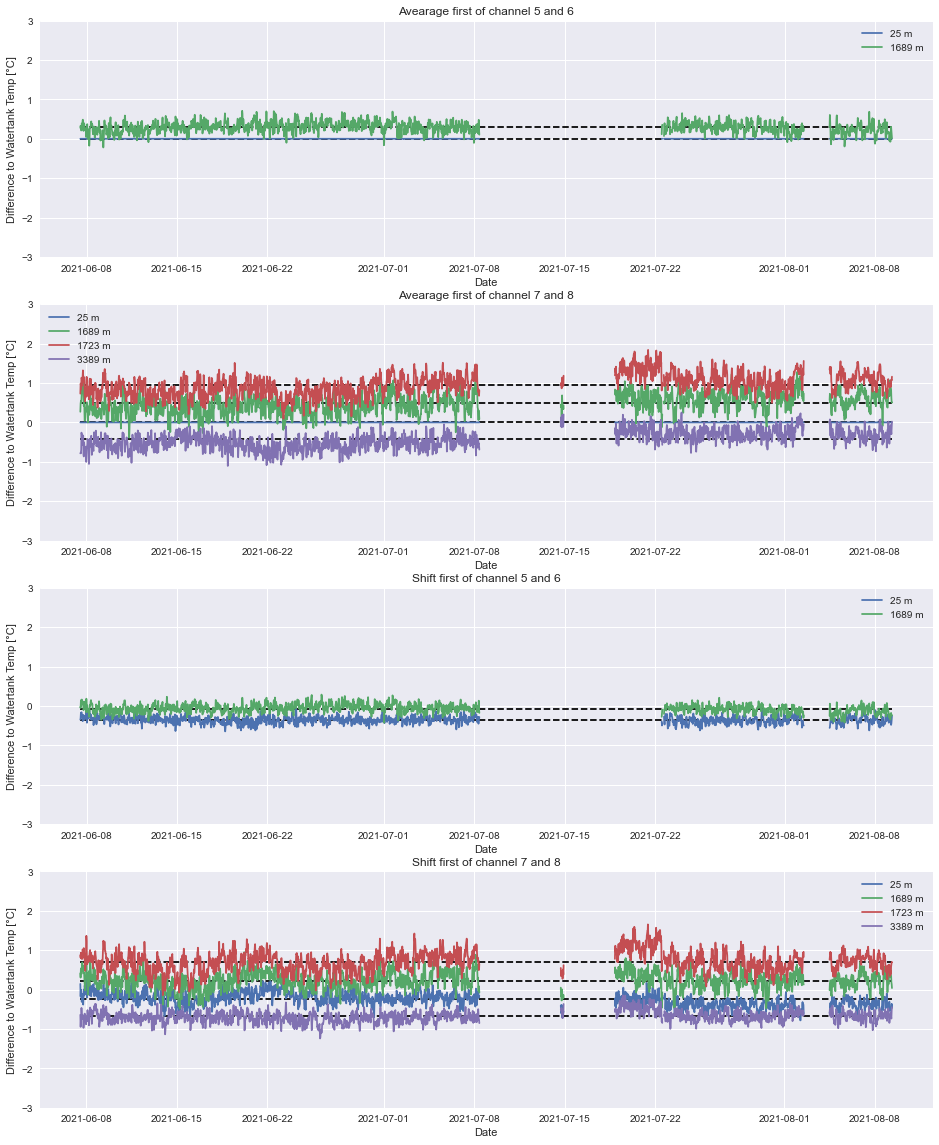

In [21]:
# Plot differences to watertank temperature over time: Avearege first
def plot_helper_9000(diff_watertank_data,mean_diff_data,w_positions,type,name):
    """w_positions: watertank position index you want to plot"""
    for w_pos in w_positions: #watertank position
        w_length = diff_watertank_data[name].index[w_pos] #watertank length
        index=diff_watertank_data[name].iloc[w_pos].index
        values=diff_watertank_data[name].iloc[w_pos].values
        ax.plot(index,values,label=f"{w_length} m")
        ax.hlines(mean_diff_data["mean: "+name].loc[w_length],index.min(),index.max(),linestyle="--",color="black")
    ax.legend()
    n=name.partition("and")
    ax.set_title(f"{type} of channel {n[0]} {n[1]} {n[2]}")
    ax.set_ylabel("Difference to Watertank Temp [°C]")
    ax.set_xlabel("Date")
    ax.set_ylim(-3,3)

fig,axs=plt.subplots(4,1,figsize=[16,20])
type_name="Avearage first"
counter_ax=0
for ax in axs[0:2]:
    if counter_ax==0:
        plot_helper_9000(diff_watertank_avearagefirst,mean_stdev_avearagefirst,[0,1],type=type_name, name="5and6")
        
    if counter_ax==1:
        plot_helper_9000(diff_watertank_avearagefirst,mean_stdev_avearagefirst,[0,1,2,3],type=type_name, name="7and8")
    counter_ax+=1

# Plot differences to watertank temperature over time: Shift first
type_name="Shift first"
counter_ax=0
for ax in axs[2:4]:
    if counter_ax==0:
        plot_helper_9000(diff_watertank_shiftfirst,mean_stdev_shiftfirst,[0,1],type=type_name,name="5and6")
        
    if counter_ax==1:
        plot_helper_9000(diff_watertank_shiftfirst,mean_stdev_shiftfirst,[0,1,2,3],type=type_name,name="7and8")
    counter_ax+=1

if plot_save:
    name="avearage_temp_diff_watertank.png"
    plt.savefig("pictures/"+name)
    plt.savefig("pictures/dpi720/"+name,dpi=720)

In [22]:
#%%time
# Wall time: 1min 35s
# calc differnce between two channels

# Difference for processed data
diff_processed_data=defaultdict(dict)
pairs=[["5","6"],["5","7"],["5","8"],["6","7"],["6","8"],["7","8"]]
all_dates=[] #for determing date range later
for pair in pairs:
    f_ch=pair[0] #first channel
    s_ch=pair[1] #second_channel

    data1 = data_all_processed_shifted[f_ch]
    data2 = data_all_processed_shifted[s_ch]


    ##############I should create an seperate named entry if one channel is flipped and adapt the following code
    ##########################################################################################

    # flip one dataframe, because its also done in avearaging two channels. 5 and 7 are flipped
    # for all others it doesnt matter, because I did not calculate a mean of them and because they are from different fibers
    if f_ch == "5" and s_ch =="6" or f_ch=="7" and s_ch=="8":
        data1_flipped=deepcopy(data1) # without deepcopy I would flip this dataframe for the rest of the notebook
        data1_flipped.columns = data1_flipped.columns[::-1]
        diff_processed_data[f"{f_ch} - {s_ch}"] = calc_diff_between_channels(data1_flipped,data2)
    else:
        diff_processed_data[f"{f_ch} - {s_ch}"] = calc_diff_between_channels(data1,data2)

# only get dates for last pair
dates=diff_processed_data[f"{f_ch} - {s_ch}"]["diff"].columns
all_dates.append(dates)
all_dates = np.array(all_dates)

# Calculate mean difference (over time)
def mean_diff_channels(dic_diff):
    """calc mean difference for each pair at the moment only for `normal diff` """
    diff_type="diff" #erstmal nur das benutzen (normale differenz)
    long_exists=False
    mean_diff = pd.DataFrame()
    mean_diff_long = pd.DataFrame() # channel 7-8 are longer, different dataframe needed or a lot of nan values in one dataframe
    for pair in dic_diff.keys():
        if pair == "7 - 8": # longer dataframe
            mean_diff_long[pair] = dic_diff[pair][diff_type].mean(axis=1)
            long_exists=True
        else:
            mean_diff[pair] = dic_diff[pair][diff_type].mean(axis=1)

    if long_exists==True:
        return mean_diff, mean_diff_long
    else:
        return mean_diff

mean_diff, mean_diff_long = mean_diff_channels(diff_processed_data)

### Some Interpretation for mean_diff
* sollte `watertank_len[0]` length nicht 0 sein? 
  * --> Difference of watertank temperature (of my watertank temperature interpolating function) at the two different dates of both channels; So this somewhat shows the accuaracy of the PT100 Logger, when assuming the temperature should be constant.

In [23]:
# Difference between both avearage data
diff_both_avearagefirst=defaultdict(dict)
diff_both_shiftfirst=defaultdict(dict)
pairs=["5and6","7and8"]
all_dates_avearagefirst=[] #for determing date range later
all_dates_shiftfirst=[]

f_pair=pairs[0] #first avearage pair
s_pair=pairs[1] #second avearage pair

data1 = chan_mean_avearagefirst[f_pair]
data2 = chan_mean_avearagefirst[s_pair]
diff_both_avearagefirst[f"{f_pair} - {s_pair}"] = calc_diff_between_channels(data1,data2)

data1 = chan_mean_shiftfirst[f_pair]
data2 = chan_mean_shiftfirst[s_pair]
diff_both_shiftfirst[f"{f_pair} - {s_pair}"] = calc_diff_between_channels(data1,data2)

all_dates_avearagefirst.append(diff_both_avearagefirst[f"{f_pair} - {s_pair}"]["diff"].columns)
all_dates_shiftfirst.append(diff_both_shiftfirst[f"{f_pair} - {s_pair}"]["diff"].columns)

all_dates_avearagefirst = np.array(all_dates_avearagefirst).flatten()
all_dates_shiftfirst = np.array(all_dates_shiftfirst).flatten()

# Calculate mean
mean_diff_avearagefirst = mean_diff_channels(diff_both_avearagefirst)
mean_diff_shiftfirst = mean_diff_channels(diff_both_shiftfirst)

# # Difference channel avearage data compare different calculation methods
# dic_diff_5and6 = {}
# dic_diff_7and8 = {}
# pairs=[["5and6","7and8"]]
# all_dates_5and6=[] #for determing date range later
# all_dates_7and8=[]
# for pair in pairs:
    
#     f_ch=pair[0] #first channel
#     s_ch=pair[1] #second_channel

#     data1 = corrected_val_avearagefirst[f_ch]
#     data2 = chan_mean[f_ch]

#     data3 = corrected_val_avearagefirst[s_ch]
#     data4 = chan_mean[s_ch]

#     df_diff_5and6 = calc_diff_between_channels(data1,data2)
#     df_diff_7and8 = calc_diff_between_channels(data3,data4)

#     all_dates_5and6.append(df_diff_5and6.columns)
#     all_dates_7and8.append(df_diff_7and8.columns)

#     dic_diff_5and6[f"{f_ch}"] = df_diff_5and6
#     dic_diff_7and8[f"{s_ch}"] = df_diff_7and8

# all_dates_5and6 = np.array(all_dates_5and6).flatten()
# all_dates_7and8 = np.array(all_dates_7and8).flatten()


# # Calculate mean
# mean_diff_5and6 = mean_diff_channels(dic_diff_5and6)
# mean_diff_7and8 = mean_diff_channels(dic_diff_7and8)

# #no time diff between different channels is expected 

# Plot differences

In [24]:
def plot_one_ax_mean_diff(mean_diff,mean_diff_long,pairs):
        """plots the mean diff between two channels"""
        mean_diff_plot=mean_diff
        
        for pair in pairs:
                if pair == "7 - 8":
                        ax.plot(mean_diff_long[pair].index,mean_diff_long[pair].values,label=pair)
                        mean = np.nanmean(mean_diff_long[pair].values)
                        ax.hlines(mean,0,3400,linestyle="--", color="black",label = "mean")
                else:
                        ax.plot(mean_diff_plot[pair].index,mean_diff_plot[pair].values,label=pair)
                        mean=np.nanmean(mean_diff_plot[pair].values)
                        ax.hlines(mean,0,1700,linestyle="--",color="black")

        ax.set_xlabel("Length [m]")
        ax.set_ylabel(f"Difference [°C]")
        #bei größerer Zeitspanne ggf .date benutzen um sekunden wegzulassen
        mi_date=pd.Timestamp(all_dates.min()).round(freq="H")
        ma_date=pd.Timestamp(all_dates.max()).round(freq="H")
        ax.set_title(f"Mean Difference between processed corrected values\nfrom {mi_date} to {ma_date}")
        ax.legend()

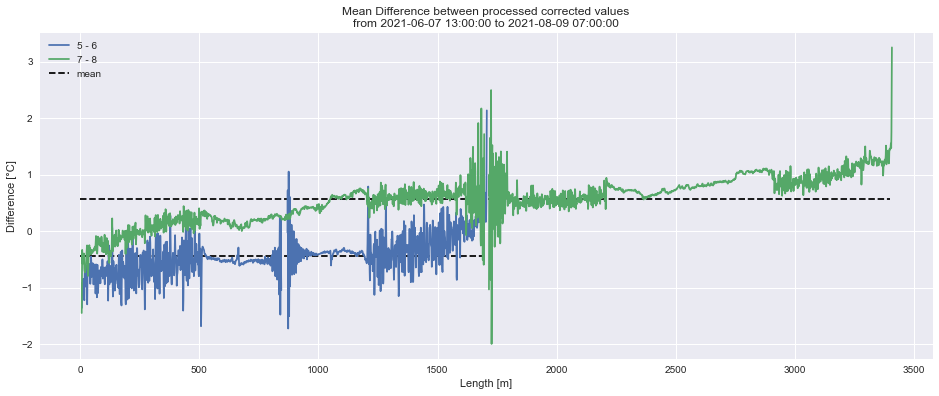

In [25]:
# Plot mean differences of corrected processed Temperature
# I could also plot other diff like relative or absolute
fig,axs=plt.subplots(1,1,figsize=[16,6])
pairs=["5 - 6","7 - 8"]#,"5-7","5-8","6-7","6-8"] #pairs for plotting, have to be in mean_diff.keys()
ax=axs
plot_one_ax_mean_diff(mean_diff,mean_diff_long,pairs)

if plot_save:
    name="temp_difference_chan56_chan78.png"
    plt.savefig("pictures/"+name)
    plt.savefig("pictures/dpi720/"+name,dpi=720)

# plot the channel data, from a random date, so that the datapoints which are used for the mean calculation are plotted at the same length
# to take a look if I should delete some length
# ax.scatter(data_all_processed_shifted["5"].iloc[30].index[::-1],data_all_processed_shifted["5"].iloc[30].values,label="channel 5; one date",s=1)
# ax.scatter(data_all_processed_shifted["6"].iloc[30].index,data_all_processed_shifted["6"].iloc[30].values,label="channel 6; one date",s=1)
# ax.vlines([505,663],-5,30,color="black",label="helperline",zorder=0,linewidth=1)
# ax.legend()

# High peaks mean, that maybe each cable position is not substracted from its partner. Length description could be wrong
# Ich denke aber, dass dies hier nicht der Fall ist.
# High peaks at 5 and 6 in the middle are from fibre damage? these channels show a very high peak when plotting them individually. I guess the fibre is damaged (mechanical highly influenced) and therfore influences the data around it
# vorallem bei 7 - 8 ist auch ein Trend zu sehen der durch das avearage ausgeglichen wird; Bei 5 - 6 ist dieser eher nur zu erahnen
# Evntl sind channel 5 und 6 um einen Messpunkt noch verschoben, da bei diff von Channel 7 und 8 der Wasserübergang nicht als Steigung in Differenz auftaucht. Habe löschen probiert peaks (bei ca. 700 und 1100) gingen nicht weg.

# Trend der über die Länge zu sehen ist (besser in 7 - 8), kommt im Endeffekt (auch) von der Verschiebung auf das Wassertank Nivaue. Da ich das bei jedem Channel bei der watertank_len[0] position mache. Nach dem flippen ist also der eine Channel am Anfang (nahe bei 0) und der andere am Ende auf das Wassertank Nivaue korrigiert.

mean 0.10453677172875056
min 0.10453677172874021
max 0.10453677172875486


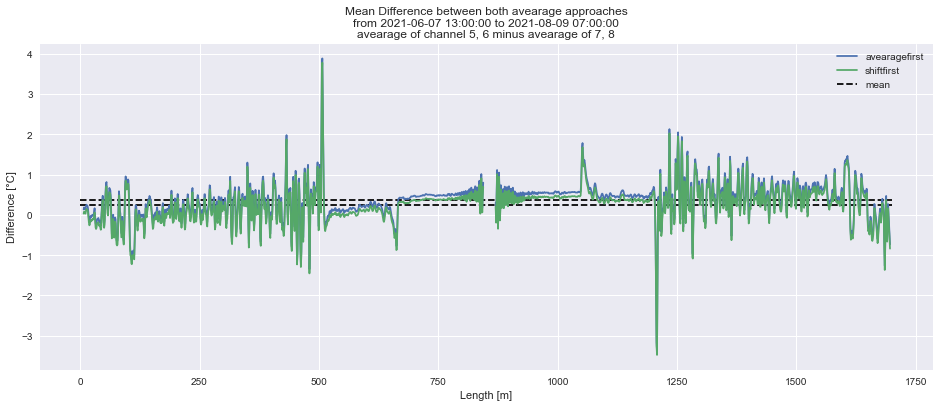

In [26]:
def plot_one_ax_mean_diff_2(mean_diff, name):
        """plots the diffs list, each in one axis"""
        pairs=["5and6 - 7and8"]

        # extract channel name from pairs
        partition0=pairs[0].partition("-")
        chan1=partition0[0].partition("and")[0]
        chan2=partition0[0].partition("and")[2][0]
        chan3=partition0[2].partition("and")[0][1]
        chan4=partition0[2].partition("and")[2]

        ax.plot(mean_diff[pairs].index,mean_diff[pairs].values,label=f"{name}")

        ax.set_xlabel("Length [m]")
        ax.set_ylabel(f"Difference [°C]")
        #bei größerer Zeitspanne ggf .date benutzen um sekunden wegzulassen
        if name == "avearagefirst":
                all_dates=all_dates_avearagefirst
        elif name == "shiftfirst":
                all_dates=all_dates_shiftfirst
        mi_date=pd.Timestamp(all_dates.min()).round(freq="H")
        ma_date=pd.Timestamp(all_dates.max()).round(freq="H")
        ax.set_title(f"Mean Difference between both avearage approaches\nfrom {mi_date} to {ma_date}\navearage of channel {chan1}, {chan2} minus avearage of {chan3}, {chan4}")
        ax.legend()

# Plot mean differences of corrected processed avearged Temperature
fig,axs=plt.subplots(1,1,figsize=[16,6])#,constrained_layout=True)
ax=axs

plot_one_ax_mean_diff_2(mean_diff_avearagefirst,"avearagefirst")
mean=np.nanmean(mean_diff_avearagefirst["5and6 - 7and8"].values)
ax.hlines(mean,0,1700,linestyle="--",color="black",label="mean")

plot_one_ax_mean_diff_2(mean_diff_shiftfirst, "shiftfirst")
mean=np.nanmean(mean_diff_shiftfirst["5and6 - 7and8"].values)
ax.hlines(mean,0,1700,linestyle="--",color="black")

if plot_save:
        name="compare_result_avearage_approaches.png"
        plt.savefig("pictures/" + name)
        plt.savefig("pictures/dpi720/" + name, dpi=720)

# Egal welchen Berechnungsanstaz ich nehme DIfferenzen sind sehr ähnlich zwischen beiden avearage Paaren. Konst offset + eine sehr kleine Schwankung
mean=(mean_diff_avearagefirst["5and6 - 7and8"] - mean_diff_shiftfirst["5and6 - 7and8"]).mean()
mini=(mean_diff_avearagefirst["5and6 - 7and8"] - mean_diff_shiftfirst["5and6 - 7and8"]).min()
maxi=(mean_diff_avearagefirst["5and6 - 7and8"] - mean_diff_shiftfirst["5and6 - 7and8"]).max()
print(f"mean {mean}")
print(f"min {mini}")
print(f"max {maxi}")

### Interpretation:
differenz ist konstant: `difffff=mean_diff_chanmean - mean_diff_aveargefirst`

Vorallem im wichtigen Teil (Schacht) ist die Differenz gering. In der Mitte steigt sie durch fibre break / meachanicle stressed. Allgemein scheint mean 7 und 8 dann besser zu sein. Eine Möglichkeit 5 und 6 zu verbessern wäre indem ich verschiedene Length position von einem Channel mittle um ihn um weniger als einen Meter zu verschieben.

#### Erklärung: 
a,b: wahre Temp; a+s1,a+s2: Anzeige Temp DTS Gerät

avearage first: Shift ist nicht konstant über Kabellänge
* a+s1   b+s2
* c=(a+s1+b+s2)/2=(a+b)/2+(s1+s2)/2
* d=(a+b)/2+(s1+s2)/2+swatertank

shift before avearage - **norbert sinvoller**
* a+s1+swater1   b+s2+swater2
* d=(a+s1+swater1+b+s2+swater2)2
* =(a+b)/2+(s1+s2)/2+(swater1+swater2)/2

Differenz zwischen beiden Ansätzen is dann swatertank - (swater1+swater2)/2

In [27]:
# # Plot mean differences of corrected processed Temperature
# fig,axs=plt.subplots(1,1,figsize=[17,9],constrained_layout=True)
# for pair in mean_diff_5and6.keys():
#     axs.plot(mean_diff_5and6[pair].index,mean_diff_5and6[pair].values,label=f"5and6\n{pair}",linewidth=7)
# for pair in mean_diff_7and8.keys():
#     axs.plot(mean_diff_7and8[pair].index,mean_diff_7and8[pair].values,label=f"7and8\n{pair}")
# axs.set_xlabel("Length [m]")
# axs.set_ylabel("Difference [°C]")
# #bei größerer Zeitspanne ggf .date benutzen
# mi_date=pd.Timestamp(all_dates_5and6.min()).round(freq="H")
# ma_date=pd.Timestamp(all_dates_5and6.max()).round(freq="H")
# axs.set_title(f"Mean Difference between the different calculation approaches\nfrom {mi_date} to {ma_date}")
# axs.legend()

# ergibt das Sinn oder habe ich einen Fehler gemacht?
# Es bedeutet:
# ob ich avearge first mache oder nicht hat keinen Einfluss auf unterschied zwischen den beiden Temperaturen der jeweiligen Berechnung
# simple überlegunf sagt eigentlich, dass bei beiden ansätzen das gleiche raus kommen muss
# ??????????????????????????
# ##############überprüfen

In [28]:
# Plot difference of back and forth from mean channel 7 and 8. These measure the same Positions and therfore there shouldnt be a big difference
# this plot is a comparrisson for the plot in analysis_shaft_temperature.ipynb

# :1700 and :1700 -1 for complete cable
# is 850 really exactly at the bendpoint?
bendpoint = 857 #[m] #same bendpoint as in exported shaft temperature
forward_columns = chan_mean_shiftfirst["7and8"].columns[:bendpoint-5]
backward_columns = chan_mean_shiftfirst["7and8"].columns[bendpoint-7:bendpoint-7+bendpoint-5]
forward=chan_mean_shiftfirst["7and8"][forward_columns]
backward=chan_mean_shiftfirst["7and8"][backward_columns]
backward.columns=forward.columns[::-1]

diff_for_back = forward - backward  # some nan at begninning due to deleting splice position

In [29]:
# calc mean and standart deviation for every depth
diff_statistic=pd.DataFrame(columns=diff_for_back.columns,index=["mean","stdev"])
diff_statistic.index.names=["Statistic"]
for depth in diff_for_back.columns:
    data_array=np.array(diff_for_back[[depth]]).flatten() # transform column to numpy array
    mean=np.nanmean(data_array)
    stdev=np.nanstd(data_array)
    diff_statistic[[depth]]=[[mean],[stdev]]
stdev_mean=diff_statistic.loc["stdev"].mean()

<ipython-input-29-3286f305e5fd>:6: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(data_array)
C:\Users\Mathis\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


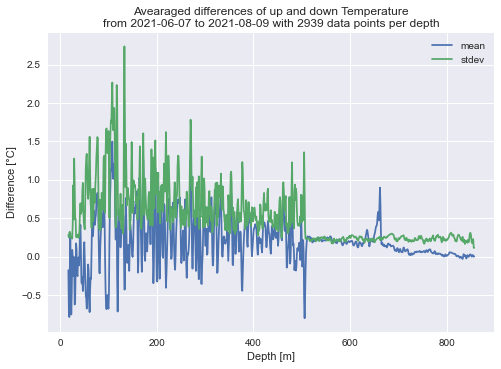

In [30]:
# Plot Difference Statistics

plt.plot(diff_statistic.loc["mean"].index,diff_statistic.loc["mean"].values,label="mean")
plt.plot(diff_statistic.loc["stdev"].index,diff_statistic.loc["stdev"].values,label="stdev")
#plt.hlines([stdev_mean],0,350,color="black",linestyle="--")
#plt.ylim(-0.1,0.5)
plt.xlabel("Depth [m]")
plt.ylabel("Difference [°C]")
plt.legend()
min_date = diff_for_back.index.min().strftime("%Y-%m-%d")
max_date = diff_for_back.index.max().strftime("%Y-%m-%d")
n = len(diff_for_back.index)
plt.title(f"Avearaged differences of up and down Temperature\nfrom {min_date} to {max_date} with {n} data points per depth")
plt.show()

In [31]:
# # Das gleiche für channel 56
# bendpoint = 857 #[m] #same bendpoint as in exported shaft temperature
# forward_columns = chan_mean_shiftfirst["5and6"].columns[:bendpoint-5]
# backward_columns = chan_mean_shiftfirst["5and6"].columns[bendpoint-7:bendpoint-7+bendpoint-5]
# forward=chan_mean_shiftfirst["5and6"][forward_columns]
# backward=chan_mean_shiftfirst["5and6"][backward_columns]
# backward.columns=forward.columns[::-1]

# diff_for_back = forward - backward  # some nan at begninning due to deleting splice position


# # calc mean and standart deviation for every depth
# diff_statistic=pd.DataFrame(columns=diff_for_back.columns,index=["mean","stdev"])
# diff_statistic.index.names=["Statistic"]
# for depth in diff_for_back.columns:
#     data_array=np.array(diff_for_back[[depth]]).flatten() # transform column to numpy array
#     mean=statistics.mean(data_array)
#     stdev=statistics.stdev(data_array)
#     diff_statistic[[depth]]=[[mean],[stdev]]
# stdev_mean=diff_statistic.loc["stdev"].mean()


# # Plot Difference Statistics

# plt.plot(diff_statistic.loc["mean"].index,diff_statistic.loc["mean"].values,label="mean")
# plt.plot(diff_statistic.loc["stdev"].index,diff_statistic.loc["stdev"].values,label="stdev")
# #plt.hlines([stdev_mean],0,350,color="black",linestyle="--")
# #plt.ylim(-0.1,0.5)
# plt.xlabel("Depth [m]")
# plt.ylabel("Difference [°C]")
# plt.legend()
# min_date = diff_for_back.index.min().strftime("%Y-%m-%d")
# max_date = diff_for_back.index.max().strftime("%Y-%m-%d")
# n = len(diff_for_back.index)
# plt.title(f"Avearaged differences of up and down Temperature\nfrom {min_date} to {max_date} with {n} data points per depth")
# plt.show()

In [32]:
# mean difference over all dates and depth
# könnte man auch noch mehr stistik zu rausgeben
(Schacht_7and8_0_down - Schacht_7and8_0_up).mean().mean()

0.14251660731985524

In [33]:
#

# Checks
print farbig machen, relativ weit scrollen scheint eine ugt Lösung zu sein. Noch nicht getestet:
https://stackoverflow.com/questions/16816013/is-it-possible-to-print-using-different-colors-in-ipythons-notebook

In [34]:
# Checks
# check if everything works as expected
# both same result, compare with diff_betweenChan_aftercorr_all_dates, to see that the 19 row in this dataframe 
# is the difference between the measured watertank temperature of the PT100
# (interpolated with a function between the data points)
# first calc
val2=temp_watertank_func(['2021-06-07 18:52:39'], df_Tlogger_PT100)
val1=temp_watertank_func(['2021-06-07 18:56:39'], df_Tlogger_PT100)
calc1=val1[0]-val2[0]

# second calc
date_check_ch5='2021-06-07 18:52:39'
timestamp_ch5=pd.Timestamp(date_check_ch5)
date_check_ch6='2021-06-07 18:56:39'
timestamp_ch6=pd.Timestamp(date_check_ch6)
calc2=data_all_processed_shifted["5"][watertank_len[0]][timestamp_ch5] - data_all_processed_shifted["6"][watertank_len[0]][timestamp_ch6]

if abs(calc1) != abs(calc2):
    print("Is there something wrong?");print(calc1);print(calc2)
    print("maybe you changed round in watertank_shift() function")

# Plots

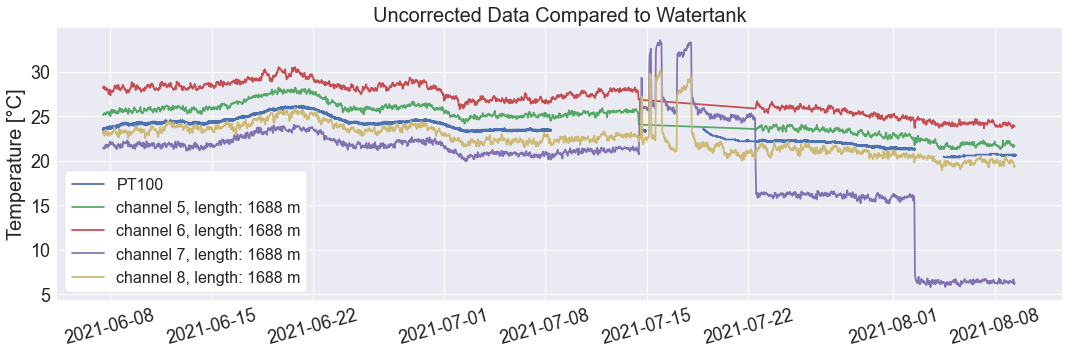

In [39]:
# Compare watertank to uncorrected channels
#ACHTUNG!! bei processing lösche ich einige Werte, sodass index sich ändert!!!
watertank_EGRT = 1688 #1689 # ich muss mir angucken welche Länge bei Mittelung mit dieser gemittelt wird um zu sehen, ob diese Länge
# evntl. schon sußerhalb vom Wassertank ist

#start = 
#end = 15800

fig, axs = plt.subplots(figsize=(18,5))
axs.plot(df_Tlogger_PT100.index[:], df_Tlogger_PT100["Channel1-Watertank_PT100"][:], label="PT100")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["5","6","7","8"]: #["7","8"]: #: 
    inde=data_2021[c][str(df_Tlogger_PT100.index[:].min()) : str(df_Tlogger_PT100.index[:].max())][watertank_EGRT].index
    val=data_2021[c][str(df_Tlogger_PT100.index[:].min()) : str(df_Tlogger_PT100.index[:].max())][watertank_EGRT].values
    d=data_2021[c][str(df_Tlogger_PT100.index[:].min()) : str(df_Tlogger_PT100.index[:].max())][watertank_EGRT].name
    axs.plot(inde,val, label=f"channel {c}, length: {d} m")

    # inde=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][1707-watertank_EGRT].index
    # val=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][1707-watertank_EGRT].values
    # plt.plot(inde,val, label=f"channel {c} length {1707-watertank_EGRT}")

font=20
axs.set_ylabel("Temperature [°C]",fontsize=font)
#axs.set_xlabel("Date",fontsize=16)
axs.set_title("Uncorrected Data Compared to Watertank",fontsize=font)
axs.tick_params(axis='x', which='major', labelsize=font-2, labelrotation=15)
axs.tick_params(axis='y', which='major', labelsize=font-2, labelrotation=0)
legend = axs.legend(fontsize=font-4, frameon=True)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor("white")

#plt.savefig("pictures/raw_data_compared_to_watertank.png",dpi=720,bbox_inches="tight")

In [36]:
# # diff steigt mit länge des Kabels
# diff=np.abs(corrected_val["7"] - corrected_val["8"])
# diff_clean=np.delete(diff,np.where(diff > 6)) #remove outliers
# leng=len(diff_clean)
# x=np.arange(0,leng)

# plt.plot(x,diff_clean,label="diffs")
# a,b=np.polyfit(x,diff_clean,deg=1)

# plt.plot(x,b+a*x,label="linear fit")
# plt.legend()
# print(f"{a},    {b}")

In [37]:
# write_pickle("final_shiftfirst",chan_mean_shiftfirst["7and8"])
# write_pickle("final_shiftfirst_56",chan_mean_shiftfirst["5and6"])